In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, brier_score_loss
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [3]:
path = '/Users/maksimshabirovs/Downloads/dataset/wdbc.data' # This path is hardcoded. Adjust it to your system if needed.
df = pd.read_csv(path)
df.columns = ['ID','Diagnosis','radius1','texture1','perimeter1',
              'area1','smoothness1','compactness1','concavity1','concave_points1',
             'symmetry1','fractal_dimension1','radius2','texture2','perimeter2',
              'area2','smoothness2','compactness2','concavity2','concave_points2',
             'symmetry2','fractal_dimension2','radius3','texture3','perimeter3',
              'area3','smoothness3','compactness3','concavity3','concave_points3',
             'symmetry3','fractal_dimension3']

X = df.drop(['Diagnosis', 'ID'],axis=1)
y = []
for entry in df['Diagnosis']:
    if entry == "B":
        y.append(0)
    elif entry == "M":
        y.append(1)
        
threshold = np.mean(y)
y_binary = (y > threshold).astype(int)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
def uncertainty():
        # Define the base model without feature names
        base_model = LogisticRegression(C=1, class_weight=None, max_iter=50, penalty='l2', solver='liblinear', random_state=1)

        # Define the BaggingClassifier with 100 base models
        model = BaggingClassifier(estimator=base_model, n_estimators=100, n_jobs=-1, random_state=42)
        model.fit(X_train, y_train)  # Fit the BaggingClassifier without feature names

        y_pred = model.predict(X_test)
        recall = recall_score(y_test, y_pred)
        print(f"Recall of the Bagging Classifier Logistic Regression on the Test Set: {recall:.2f}")
        
        
        # Get the predictions from each base model in the ensemble
        predictions = np.array([estimator.predict_proba(X_test)[:, 1] for estimator in model.estimators_])

        # Calculate the 5th and 95th percentiles of the predictions
        lower_bound = np.percentile(predictions, 5, axis=0)
        upper_bound = np.percentile(predictions, 95, axis=0)
        median_predictions = np.median(predictions, axis=0)
        
        # Plot error bars for predictions
        indices = range(median_predictions.shape[0])
        plt.figure(figsize=[18,6])
        plt.errorbar(indices, median_predictions, yerr=[median_predictions - lower_bound, upper_bound - median_predictions], fmt='o',capsize=5)
        plt.scatter(indices, y_test[indices], marker='s', c='k')
        plt.title('Prediction Uncertainty for the First 100 Samples')
        plt.xlabel('Sample Index')
        plt.ylabel('Predicted Probability')
        plt.ylim(-0.1,1.1)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
        
        threshold = 0.2
        idx = upper_bound - lower_bound < threshold

        accuracy = recall_score(y_test[idx], y_pred[idx])
        decisiveness = sum(idx)/idx.shape[0]

        print(f"The Bagging Classifier Logistic Regression can give us certain decisions about {decisiveness:.2f} of the test samples with the recall of: {recall:.2f}")

In [16]:
def calibration():
    # Train uncalibrated logreg on the training set
    model = LogisticRegression(C=1, class_weight=None, max_iter=50, penalty='l2', solver='liblinear', random_state=1)
    model.fit(X_train, y_train)
    
    # Calibrate the SVC model on the validation set
    calibrated = CalibratedClassifierCV(estimator=model, cv='prefit', method='isotonic')
    calibrated.fit(X_val, y_val)
    
    # Predict probabilities on the test set
    probs = model.predict_proba(X_test)[:, 1]
    probs_calibrated = calibrated.predict_proba(X_test)[:, 1]

    # Compute calibration curve for SVC
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, probs, n_bins=10)

    # Compute calibration curve for calibrated SVC
    fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_test, probs_calibrated, n_bins=10)

    # Compute Brier scores
    brier_uncalibrated = brier_score_loss(y_test, probs)
    brier_calibrated = brier_score_loss(y_test, probs_calibrated)

    print("Brier Score (Uncalibrated):", brier_uncalibrated)
    print("Brier Score (Calibrated):", brier_calibrated)

    # Plot the calibration curve
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Uncalibrated')
    plt.plot(mean_predicted_value_calibrated, fraction_of_positives_calibrated, marker='x', label='Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

## Model Robustness at The Prediction Stage: Model Calibration

Model calibration ensures that the model's predicted probabilities accurately reflect the true likelihood of the target event. Calibrated models yield more trustworthy and interpretable probabilities, aiding informed decision-making.

Brier Score (Uncalibrated): 0.02824794054623768
Brier Score (Calibrated): 0.027025265947773228


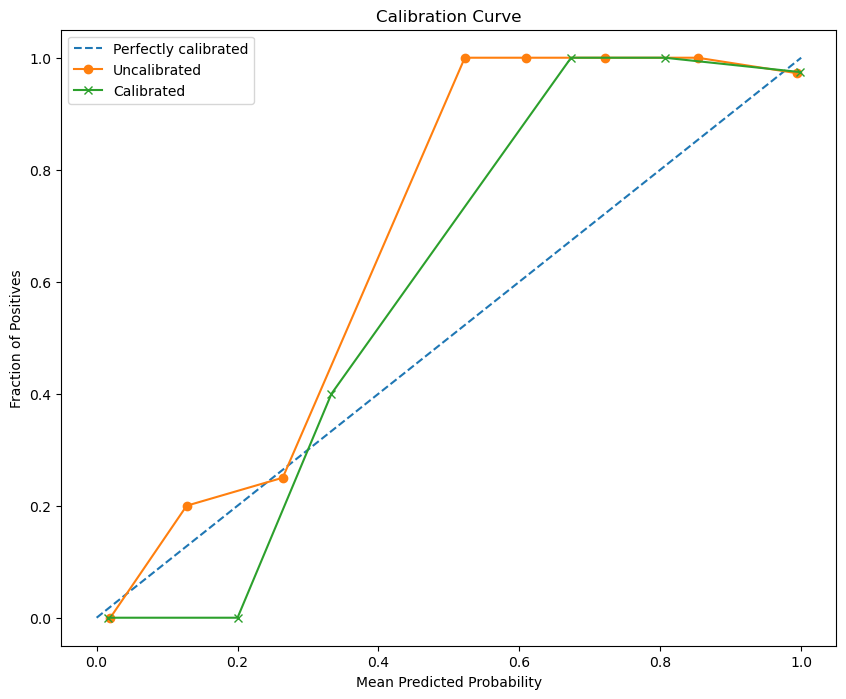

In [17]:
calibration()

## Model Robustness at The Prediction Stage: Estimating Epistemic Uncertainty using Bootstrapping Technique

Estimating epistemic uncertainty plays a crucial role in enhancing the safety of AI-based decision-making in several ways.
   
Here, we try to showcase how to use a bag of Logistic Regression to estimate the prediction uncertainty on our adapted cancer dataset. 

Recall of the Bagging Classifier Logistic Regression on the Test Set: 0.93


/Users/maksimshabirovs/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/maksimshabirovs/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/maksimshabirovs/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/maksimshabirovs/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/maksimshabirovs/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/maksimshabirovs/anaconda3/lib/python3.11/si

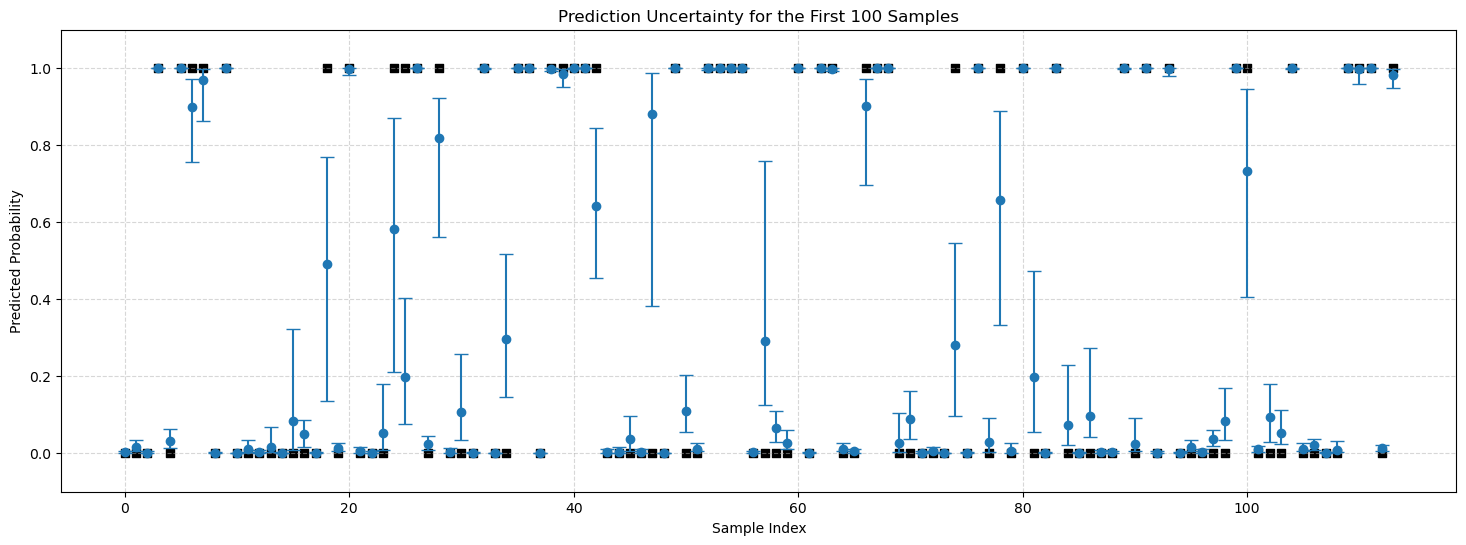

The Bagging Classifier Logistic Regression can give us certain decisions about 0.84 of the test samples with the recall of: 0.93


In [13]:
uncertainty()